In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import plot_importance
from imblearn.under_sampling import RandomUnderSampler
import sklearn as sk
import pickle

In [2]:
def df_transformation(df):
    df_temp = df[features]
    df_temp['datetime'] = df_temp.datetime.dt.strftime('%Y-%m-%d %H:%M:%S').astype('datetime64[ns]')

    output = df_temp.groupby(by=["datetime"], dropna=False).mean().reset_index()
    
    return output 

In [3]:
# Create a custom function for data transformation
# May as well import all of these features into the initial dataframe, you can cut it down..
# ..when you do the X,y train/test split
features = ['datetime',
            'latitude',
            'longitude',
            'absoluteAltitude',
            'magneticHeading',
            'trueHeading',
            'groundSpeed',
            'trueAirspeed',
            'pitch',
            'roll',
            'yaw',
            'angleOfAttack',
            'flightPathAngle',
            'verticalFlightPathAngle',
            'horizontalFlightPathAngle',
            'rollAcceleration',
            'pitchAcceleration',
            'yawAcceleration',
            'e1N1ng',
            'e2N1ng',
            'e1N2nf',
            'e2N2nf',
            'mainRotorRpm',
            'tailRotorRpm',
            'mainRotorTorque',
            'e1Itt',
            'e2Itt',
            'mainRotorInducedInflow',
            'flightDirectorPitch',
            'flightDirectorRoll',
            'climbOrDescentRate',
            'hasWeightOnWheels',
            'turnRate to degPerSec',
            'cyclicPositionPitch',
            'cyclicPositionRoll',
            'collectivePosition',
            'antiTorquePedalPosition',
            'throttlePosition',
            'e1Torque',
            'e2Torque'
           ]

In [26]:
# reading files from 9/19 dataset
df1 = pd.read_csv('SimData_2022.09.19_16.00.36.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# df1 = df_transformation(df1)


df2 = pd.read_csv('SimData_2022.09.19_16.38.20.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# df2 = df_transformation(df2)


df3 = pd.read_csv('SimData_2022.09.19_17.51.37.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# df3 = df_transformation(df3)



# reading files from 9/20 dataset
df4 = pd.read_csv('SimData_2022.09.20_16.22.07.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# df4 = df_transformation(df4)


df5 = pd.read_csv('SimData_2022.09.20_16.28.31.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# df5 = df_transformation(df5)


# reading file from 9/22 dataset
df6 = pd.read_csv('SimData_2022.09.22_17.11.56.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# df6 = df_transformation(df6)


# reading file from 10/06 dataset
df7 = pd.read_csv('SimData_2022.10.06_09.47.22.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)
# df7 = df_transformation(df7)

In [27]:
#Combine files
df = pd.concat([df1, df2, df3, df4, df5, df6, df7]).reset_index()
len(df)

306780

In [28]:
df.head()

,index,datetime,_id,latitude,longitude,gpsAltitude,absoluteAltitude,magneticHeading,trueHeading,pitch,...,hasMainRotorLowRpmWarning,hasMainRotorHighRpmWarning,hasTailRotorChipWarning,hasTransmissionChipCaution,hasTransmissionOilTemperatureWarning,hasTransmissionOilPressureWarning,timestamp,gpsDateTime,seconds,vil
0,0,2022-09-19 20:01:09.844,::1663632069.844,39.358996,-74.434692,162.29,0.03,343.894,331.555,0.480,...,False,False,False,False,False,False,2022-09-19T20:01:09.844Z,2022-09-19T20:01:09.844Z,1.663632e+09,-2
1,1,2022-09-19 20:01:09.861,::1663632069.861,39.358996,-74.434692,162.30,0.03,343.808,331.470,0.436,...,False,False,False,False,False,False,2022-09-19T20:01:09.861Z,2022-09-19T20:01:09.861Z,1.663632e+09,-2
2,2,2022-09-19 20:01:09.878,::1663632069.878,39.358996,-74.434692,162.30,0.04,343.693,331.355,0.374,...,False,False,False,False,False,False,2022-09-19T20:01:09.878Z,2022-09-19T20:01:09.878Z,1.663632e+09,-2
3,3,2022-09-19 20:01:09.907,::1663632069.907,39.358996,-74.434692,162.30,0.04,343.464,331.126,0.243,...,False,False,False,False,False,False,2022-09-19T20:01:09.907Z,2022-09-19T20:01:09.907Z,1.663632e+09,-2
4,4,2022-09-19 20:01:09.927,::1663632069.927,39.358996,-74.434692,162.30,0.04,343.370,331.031,0.187,...,False,False,False,False,False,False,2022-09-19T20:01:09.927Z,2022-09-19T20:01:09.927Z,1.663632e+09,-2


# Surface Taxi - DataFrame Labelling

In [6]:
df_s = df.copy()
df_s['surface'] = 0

df_s.loc[(df_s['datetime'].between('2022-09-19 21:53:50' , '2022-09-19 21:55:55' , inclusive='both')),['surface']] = 1
df_s.loc[(df_s['datetime'].between('2022-09-19 22:04:00' , '2022-09-19 22:06:39' , inclusive='both')),['surface']] = 1
df_s.loc[(df_s['datetime'].between('2022-09-20 20:25:50' , '2022-09-20 20:27:54' , inclusive='both')),['surface']] = 1
df_s.loc[(df_s['datetime'].between('2022-09-22 21:16:37' , '2022-09-22 21:19:56' , inclusive='both')),['surface']] = 1
df_s.loc[(df_s['datetime'].between('2022-09-22 21:43:16' , '2022-09-22 21:43:41' , inclusive='both')),['surface']] = 1
df_s.loc[(df_s['datetime'].between('2022-10-06 13:52:16' , '2022-10-06 13:56:00' , inclusive='both')),['surface']] = 1

In [7]:
#orginal class imbalance
df_s['surface'].value_counts()

0    6583
1     637
Name: surface, dtype: int64

In [8]:
#call features used in model
model_features = ['hasWeightOnWheels',
                  'absoluteAltitude',
                  'groundSpeed',
                  'climbOrDescentRate',
                  'cyclicPositionPitch',
                  'cyclicPositionRoll',
                  'collectivePosition',
                  'antiTorquePedalPosition',
                  'throttlePosition',
                  'e1Torque',
                  'e2Torque'
                 ]

In [9]:
#call OverSampler using 'majority' 
rus = RandomUnderSampler(sampling_strategy='majority')

In [10]:
#set x and y to respective features
surface_x, surface_y = df_s[model_features], df_s['surface']

In [11]:
#resample
surface_x, surface_y = rus.fit_resample(surface_x, surface_y)

In [12]:
#new class balance
surface_y.value_counts()

0    637
1    637
Name: surface, dtype: int64

# Surface Taxi - XGBoost Model

In [13]:
#train and test split for model
surface_x_train, surface_x_test, surface_y_train, surface_y_test = sk.model_selection.train_test_split(surface_x,surface_y,test_size=0.33,random_state=777)

In [14]:
#call XG Boost model and fit to data
surface_model = XGBClassifier(use_label_encoder=False, max_depth = 4, eta = .075)
surface_model.fit(surface_x_train, surface_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.075,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.075000003, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [15]:
#training model prediction
surface_train_pred = surface_model.predict(surface_x_train)

In [16]:
#test model prediction
surface_pred = surface_model.predict(surface_x_test)

In [17]:
#accuracy scores
surface_train_acc = sk.metrics.accuracy_score(surface_y_train, surface_train_pred)
surface_test_acc = sk.metrics.accuracy_score(surface_y_test, surface_pred)

In [18]:
print("Train Accuracy: %.2f%%" % (surface_train_acc * 100.0))
print("Test Accuracy: %.2f%%" % (surface_test_acc * 100.0))

Train Accuracy: 99.88%
Test Accuracy: 98.10%


In [19]:
#auc roc scores
surface_train_roc = sk.metrics.roc_auc_score(surface_y_train, surface_train_pred)
surface_test_roc = sk.metrics.roc_auc_score(surface_y_test, surface_pred)

In [20]:
print("Train ROC AUC Score: %.2f%%" % (surface_train_roc * 100.0))
print("Test ROC AUC Score: %.2f%%" % (surface_test_roc * 100.0))

Train ROC AUC Score: 99.88%
Test ROC AUC Score: 98.10%


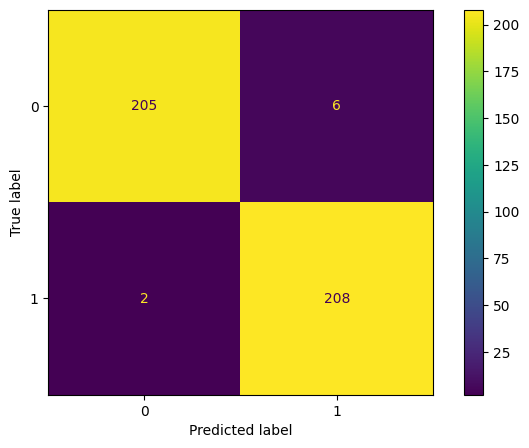

In [21]:
#confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = sk.metrics.ConfusionMatrixDisplay(sk.metrics.confusion_matrix(surface_y_test, surface_pred),)
cmp.plot(ax=ax)
plt.show()

C:\Users\kanev\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


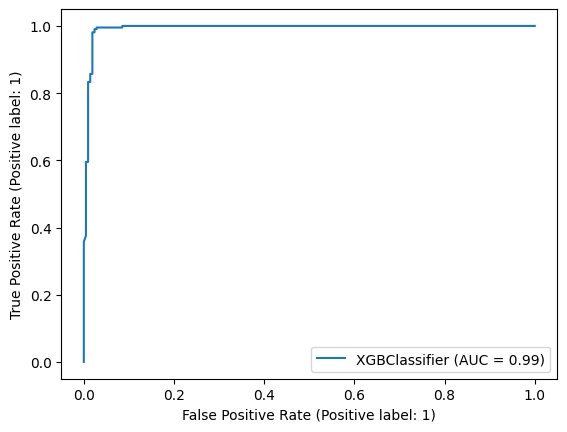

In [22]:
#auc roc plot
sk.metrics.plot_roc_curve(surface_model, surface_x_test, surface_y_test)
plt.show()

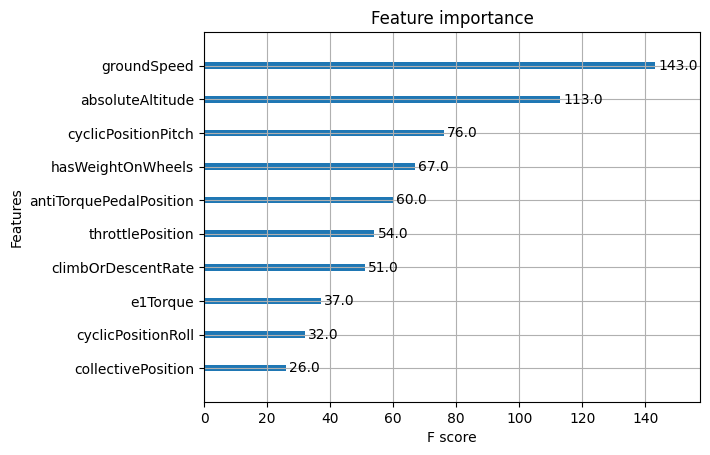

In [23]:
plot_importance(surface_model)
plt.show()

In [24]:
filename = 'final_surface_model.sav'
pickle.dump(surface_model, open(filename, 'wb'))